# 21.12.2025 | Neural Language Model


## What are we going to cover today?
We will build, train, and compare different architectures.
*   Introduction: Me, we, us.
*   Imports: Establish the environment and ensure our experiments are reproducible
* Data Engineering: From Text to Tensors (Tokenization, Vocabulary, Sliding Windows).
* Baseline N-Gram Model: Probabilistic counting (The "Old School" approach).
* CNN (Convolutional Neural Network): Detecting patterns in text.

Later:
* RNN (Recurrent Neural Network): Adding memory to sequences.
* LSTM (Long Short-Term Memory): Solving the short-term memory problem.
* GRU (Gated Recurrent Unit): Efficient memory for edge devices.



# Setup and Configs

In [ ]:
import time
import torch
import torch.nn as nn # Neural Network modules (Linear layers, RNNs, LSTMs, Loss functions)
import torch.optim as optim # Optimization algorithms (SGD, Adam)
from torch.utils.data import Dataset, DataLoader # Tools to handle data batching efficiently
import numpy as np # For numerical operations
import matplotlib.pyplot as plt # For basic plotting
import seaborn as sns # For making plots look pretty
import re # Regular Expressions for text cleaning
from collections import defaultdict, Counter, deque # Python utilities for counting words
import pandas as pd # Data manipulation (though we rely mostly on PyTorch here)

In [ ]:
# Visualization Styling
sns.set_theme(style="whitegrid") # Sets a clean grid background for plots
plt.rcParams['figure.figsize'] = [12, 6] # Sets default plot size

In [ ]:
# Reproducibility
SEED = 2025
torch.manual_seed(SEED) # Fixes random numbers for PyTorch
np.random.seed(SEED)    # Fixes random numbers for Numpy

In [ ]:
# Global History Store (To save results from each cell)
HISTORY_STORE = {} # A dictionary to save training loss curves for comparison later
PREDICTION_STORE = {} # A dictionary to save the text generated by each model

In [ ]:
#Timekeeping
def timed_run(func, *args, **kwargs):
    start = time.time()
    print("⏳ Training started...")
    result = func(*args, **kwargs)
    end = time.time()
    print("✅ Training finished.")
    print(f"⏱️ Time taken: {end - start:.2f} seconds")
    return result

# Data Engineering: Tokenization & Sliding Windows

**Concept:** Neural networks require numerical input. Cause? It cannot read text; they perform math on numbers.

*Corpus -> Tensors.*

We perform three steps:
* **Tokenization**: Breaking text into atomic units (words or sub-words). Example: "I am Human" $\rightarrow$ ["I", "am", "Human"]
$T = \{w_1, w_2, ..., w_N\}$ (Splitting text into atomic units)
* **Indexing**: Assigning a unique ID to every word. $V \rightarrow \mathbb{Z}$ (Mapping unique tokens to integers).
* **Supervised Generation (Sliding Window)**: Given a window size $k$, we generate pairs $(X, y)$:$$X_t = [w_{t}, w_{t+1}, ..., w_{t+k-1}], \quad y_t = w_{t+k}$$
We train the model to predict the next word given a specific context window.

---

**Input Corpus:** IIT Delhi Description (https://home.iitd.ac.in/about.php)

**Context**: "Indian Institute of"

**Target**: "technology"


---



In [ ]:
corpus_text = """
Indian Institute of Technology Delhi is one of the 23 IITs created to be Centres
of Excellence for training, research and development in science, engineering and
technology in India.

Established as College of Engineering in 1961, the Institute was later declared
as an Institution of National Importance under the “Institutes of Technology
(Amendment) Act, 1963” and was renamed as “Indian Institute of Technology Delhi”.
It was then accorded the status of a Deemed University with powers to decide its
own academic policy, to conduct its own examinations, and to award its own degrees.

Since its inception, over 60000 have graduated from IIT Delhi in various
disciplines including Engineering, Physical Sciences, Management and Humanities
& Social Sciences. Of these, nearly 5070 received Ph.D. degrees. The number of
students who graduated with B.Tech. degree is over 15738. The rest obtained
Master’s Degree in Engineering, Sciences and Business Administration. These
alumni today work as scientists, technologists, business managers and entrepreneurs.
There are several alumni who have moved away from their original disciplines and have
taken to administrative services, active politics or are with NGOs. In doing so,
they have contributed significantly to building of this nation, and to
industrialization around the world.
"""

In [ ]:
def preprocess_and_stats(text):
    # Clean and Tokenize
    text = text.lower() # Normalize case ("The" == "the")
    text = re.sub(r'[^a-z0-9\s]', '', text) # Regex: Remove anything that isn't a letter, number, or space
    tokens = text.split() # Splits string into a list of words based on whitespace

    # Vocabulary Construction
    vocab = sorted(list(set(tokens))) # Get unique words
    word_to_idx = {w: i for i, w in enumerate(vocab)} # Map word -> ID (e.g., 'india': 45)
    idx_to_word = {i: w for i, w in enumerate(vocab)} # Map ID -> word (for decoding later)

    print(f"Corpus Stats:")
    print(f"   - Total Token Count: {len(tokens)}")
    print(f"   - Unique Vocabulary Size: {len(vocab)}")
    print(f"\nSample Tokens: {tokens[:10]}")

    # Vocabulary Distribution
    word_counts = Counter(tokens)
    common_words = word_counts.most_common(15)

    plt.figure(figsize=(10, 4))

    sns.barplot(
        x=[w[0] for w in common_words],
        y=[w[1] for w in common_words],
        hue=[w[0] for w in common_words],  # assign hue
        palette="viridis",
        legend=False
    )

    plt.title("Top 15 Most Frequent Words")
    plt.xticks(rotation=45)
    plt.show()


    return tokens, word_to_idx, idx_to_word, len(vocab)

Corpus Stats:
   - Total Token Count: 198
   - Unique Vocabulary Size: 123

Sample Tokens: ['indian', 'institute', 'of', 'technology', 'delhi', 'is', 'one', 'of', 'the', '23']


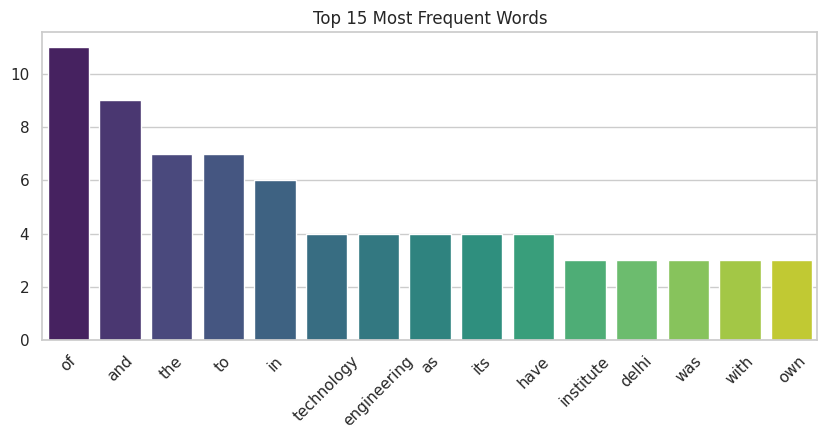

In [ ]:
# Execute Pipeline
tokens, word_to_idx, idx_to_word, VOCAB_SIZE = preprocess_and_stats(corpus_text)

In [ ]:
# Dataset Class for PyTorch
class TextDataset(Dataset):
    def __init__(self, tokens, word_to_idx, context_size=5):
        self.samples = []
        # The Loop: Slide a window across the text
        for i in range(len(tokens) - context_size):
            # Input (X): The previous 'context_size' words
            context_window = [word_to_idx[w] for w in tokens[i:i+context_size]]
            # Target (y): The very next word
            target_word = word_to_idx[tokens[i+context_size]]
            # Save as PyTorch tensors
            self.samples.append((torch.tensor(context_window), torch.tensor(target_word)))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

In [ ]:
# Hyperparameters
CONTEXT_SIZE = 3   # The AI looks at the previous 3 words to decide the next one.
BATCH_SIZE = 16    # Process 16 samples in parallel
EMBED_DIM = 32     # Vector size (richness of word representation)
HIDDEN_DIM = 64    # Memory capacity of the neural network (Neurons in the hidden layers)
EPOCHS = 150       # Training iterations.

In [ ]:
# Create Loaders
dataset = TextDataset(tokens, word_to_idx, CONTEXT_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Dimention Check
sample_batch = next(iter(dataloader))
print(f"\n Tensor Dimension Check:")
print(f"   - Input Batch Shape (X): {sample_batch[0].shape} -> [Batch_Size, Context_Size]")
print(f"   - Target Batch Shape (Y): {sample_batch[1].shape} -> [Batch_Size]")


 Tensor Dimension Check:
   - Input Batch Shape (X): torch.Size([16, 3]) -> [Batch_Size, Context_Size]
   - Target Batch Shape (Y): torch.Size([16]) -> [Batch_Size]


# N-Gram Model

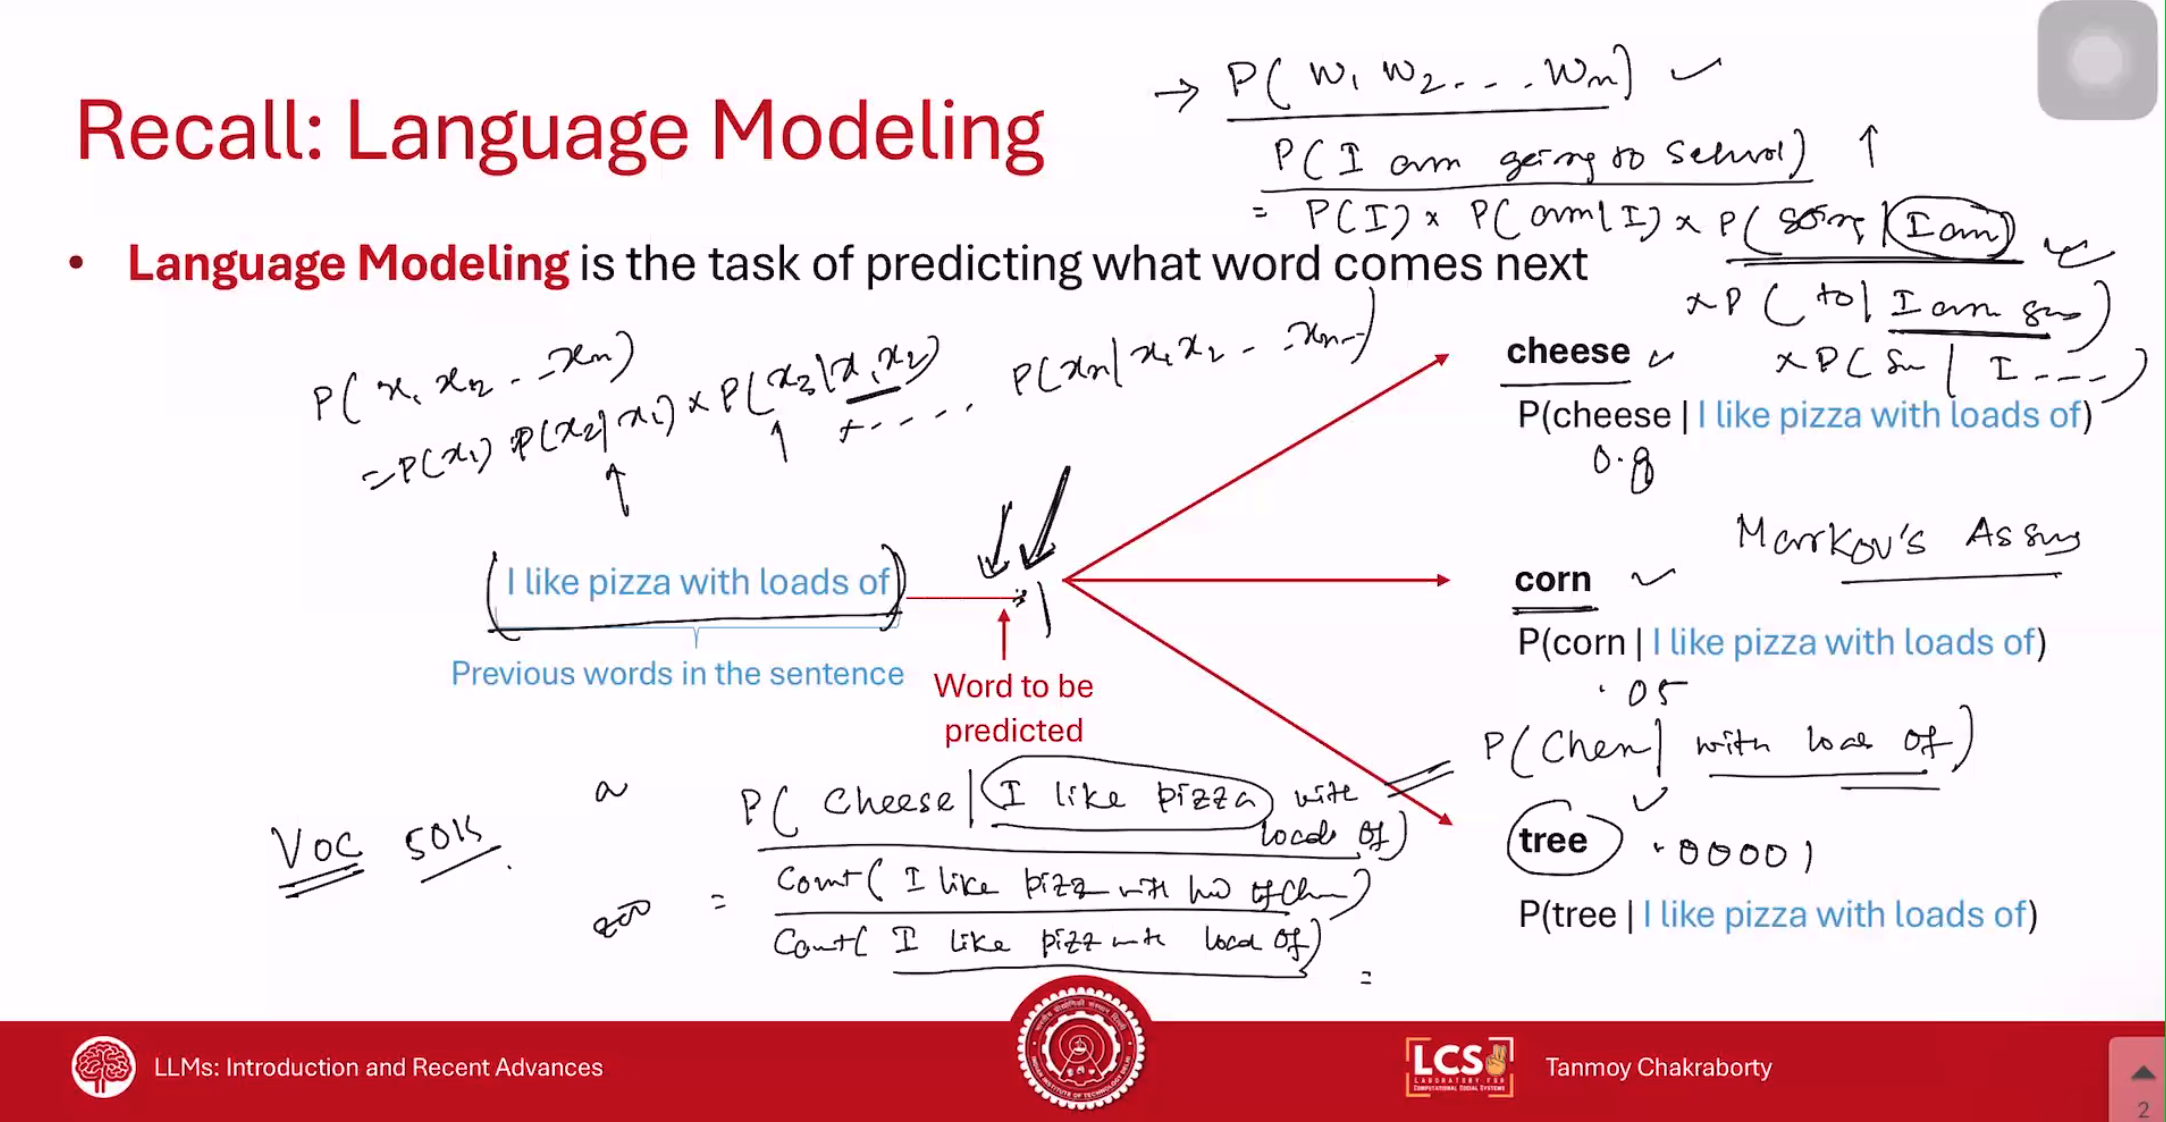

In [ ]:
# Theory: Markov Assumption (Guess the order?)
# It assumes the next word depends ONLY on the previous two words.
# Formula: P(w3 | w1, w2) = Count(w1, w2, w3) / Count(w1, w2)
# No backpropagation. Just counting.

class NGramModel:
    def __init__(self, tokens, n=3):
        self.n = n
        self.model = defaultdict(Counter)

        #cTraining = Counting
        print(f"Building {n}-Gram Statistics Table...")
        for i in range(len(tokens) - n + 1):
            history = tuple(tokens[i:i+n-1]) # Key: ('indian', 'institute', 'of')
            target = tokens[i+n-1]           # Value: 'technology'
            self.model[history][target] += 1 # Increment count

    def predict(self, prompt_text, length=10):
        words = prompt_text.lower().split()

        print(f"N-Gram Inference:")
        print(f"   Prompt: '{prompt_text}'")

        for _ in range(length):
            # Look up the history in our table, Get last n-1 words as history
            history = tuple(words[-(self.n-1):])

            # Retrieve counts
            options = self.model.get(history, None)

            if not options:
              break # Stop if we encounter a sequence we never saw in training

        # Greedy approach: Pick the word with highest count
        next_word = options.most_common(1)[0][0]
        words.append(next_word)

        result = " ".join(words)
        print(f"   Result: \"... {result} ...\"\n")
        PREDICTION_STORE["N-Gram"] = result
        return result

In [ ]:
#execute
ngram = NGramModel(tokens, n=CONTEXT_SIZE+1) # n=4 if context=3
ngram.predict("to conduct its")

Building 4-Gram Statistics Table...
N-Gram Inference:
   Prompt: 'to conduct its'
   Result: "... to conduct its own ..."



'to conduct its own'

# Training & Inference Engines

In [ ]:
def train_and_log(model, name="Model"):
    """
    Standardized Training Loop.
    Input: Model Architecture
    Output: Trained Model, Loss History
    """
    model = model.to("cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []

    print(f"\nTraining {name}...")
    model.train()

    for epoch in range(EPOCHS):
        epoch_loss = 0
        for context, target in dataloader:
            # 1. Zero out old gradients (cleaning the slate)
            optimizer.zero_grad()
            # 2. Forward Pass: Ask model for prediction
            output = model(context)
            # 3. Calculate Loss: How wrong was it?
            loss = criterion(output, target)
            # 4. Backward Pass: Calculate corrections (gradients)
            loss.backward()
            # 5. Step: Update weights
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)

        if epoch == 0 or (epoch + 1) % 50 == 0:
          print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

    # Save to global store
    HISTORY_STORE[name] = losses
    return model

In [ ]:
def run_inference(model, prompt, name="Model", length=10):
    """
    Standardized Inference Loop.
    Generates text based on the learned weights.
    """
    model.eval()
    words = prompt.lower().split()
    generated = list(words)

    print(f"{name} Inference:")
    print(f"   Prompt: '{prompt}'")

    for _ in range(length):
        # Prepare Context
        current_context = words[-CONTEXT_SIZE:]
        idxs = [word_to_idx.get(w, 0) for w in current_context]

        # Padding if necessary (for very short prompts)
        if len(idxs) < CONTEXT_SIZE:
            idxs = [0]*(CONTEXT_SIZE - len(idxs)) + idxs

        input_tensor = torch.tensor([idxs], dtype=torch.long).to("cpu")

        with torch.no_grad():
            logits = model(input_tensor)
            pred_idx = torch.argmax(logits, dim=1).item()

        next_word = idx_to_word[pred_idx]
        words.append(next_word)
        generated.append(next_word)

    result = " ".join(generated)
    print(f"   Result: \"... {result} ...\"\n")
    PREDICTION_STORE[name] = result
    return result

# Convolutional Neural Network (CNN)

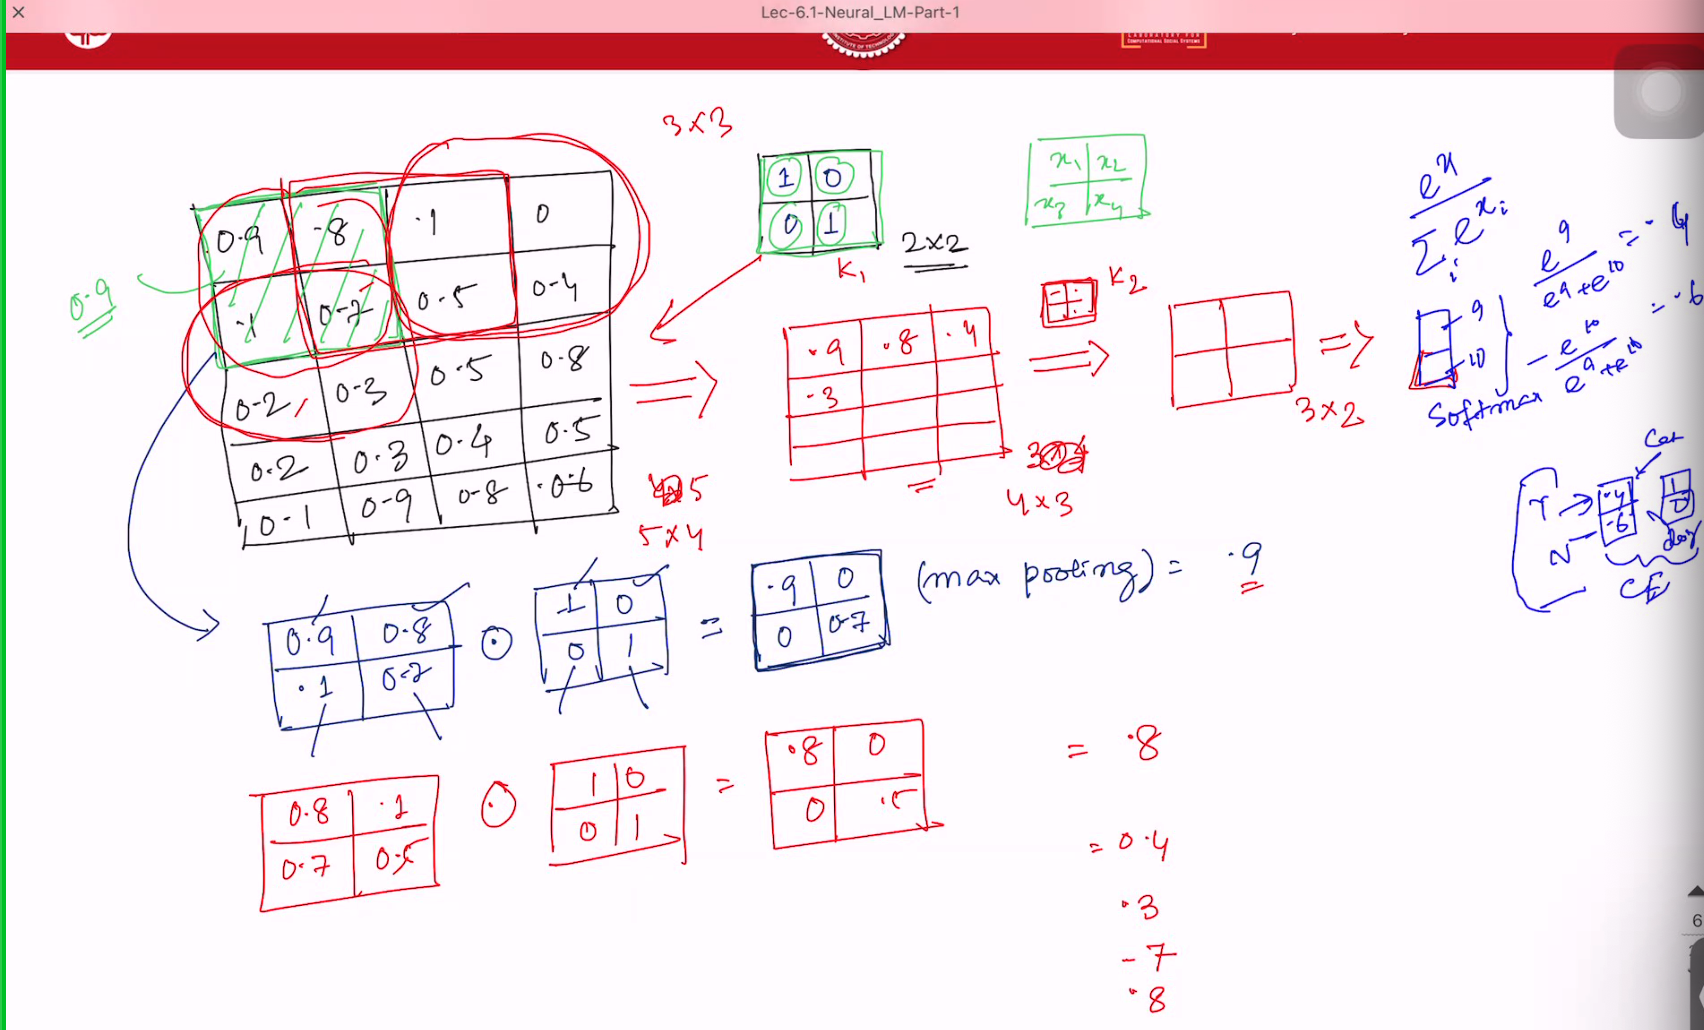

1D Convolutions on Text. Instead of processing time-step by time-step, we slide a filter (kernel) of size $k$ over the text.

Kernel size 3 $\approx$ Trigram features, **which you learn, stays same**. A "Kernel" slides over the text window (e.g., 3 words at a time) to detect specific features or phrases, regardless of where they appear in the sentence.

**Dimensions**: Inputs must be permuted.

**Labels:** Whole Vocab.

**Output:**

PyTorch Conv1d expects $(Batch, Channels, Length)$, where Channels = Embedding Dimension.

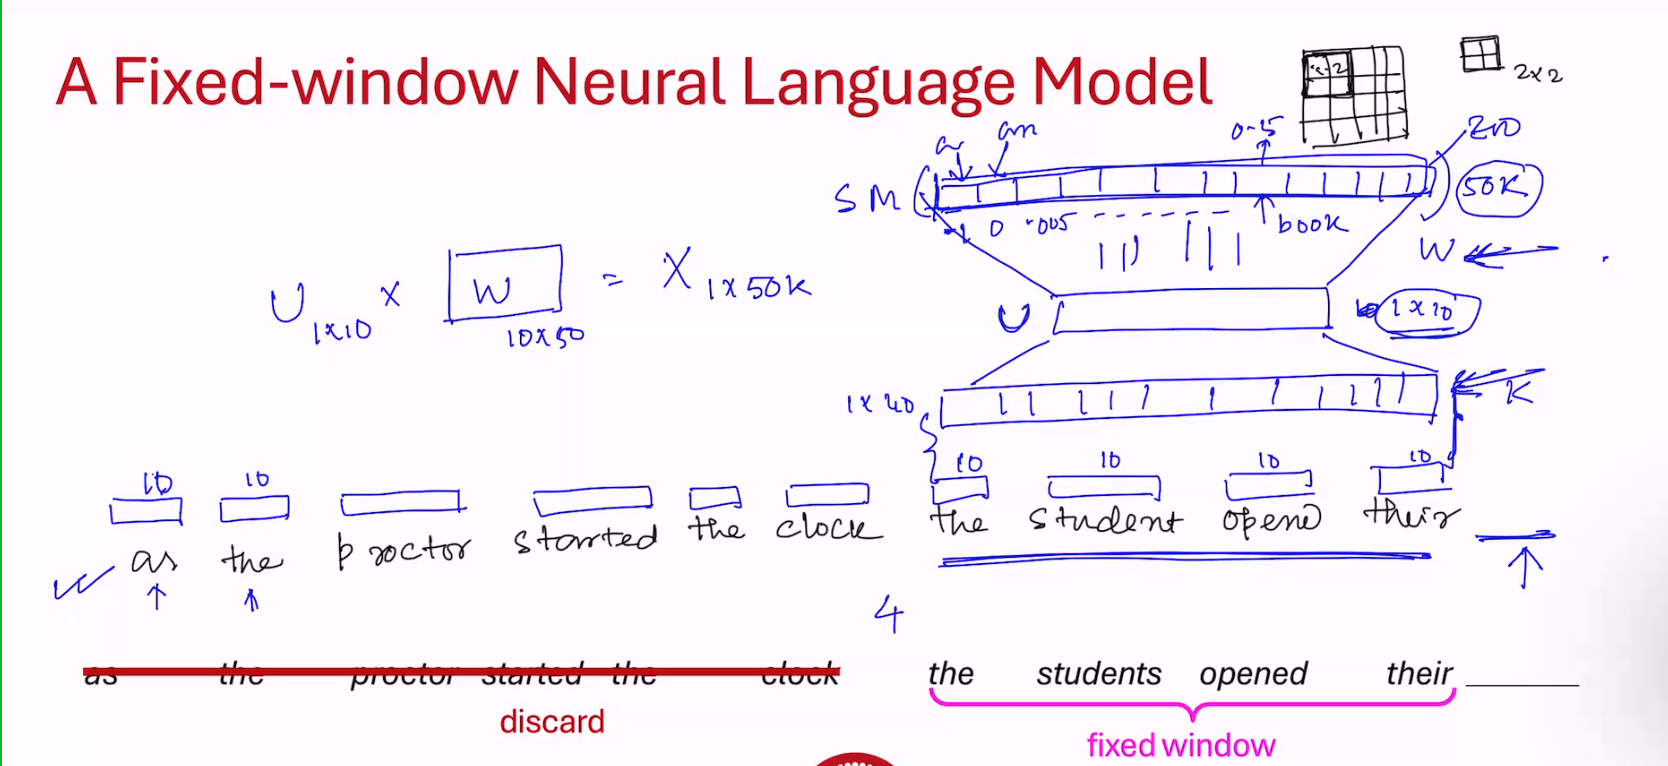

In [ ]:
# Theory: Sliding window (kernel) detects local patterns (N-grams).
# Requires permuting dimensions: [Batch, Channel, Length]
# Advantage: Unknown words can be handled; no need to store the count, only need (W, U).
# Disadvantage: Hard to choose context (never enough) and hyperparameters; information mixing is not that great!

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        # Conv1d Layer:
        # In_Channels = Embedding Dimension
        # Out_Channels = Number of filters (Hidden Dim)
        # Kernel_Size = 3 (looks at trigrams/3 words at once)
        self.conv = nn.Conv1d(EMBED_DIM, HIDDEN_DIM, kernel_size=3)

        # Pooling: Grabs the most important feature detected across the whole sequence
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(HIDDEN_DIM, VOCAB_SIZE)

    def forward(self, x):
        x = self.emb(x) # Shape: [Batch, Seq, Emb]

        # TRICKY PART: PyTorch Conv1d expects [Batch, Channels, Length]
        # So we permute (swap) dimensions 1 and 2.
        x = x.permute(0, 2, 1) # [Batch, Emb, Seq] -> Ready for Conv1d (Channels first)
        x = torch.relu(self.conv(x)) # Apply convolution + Activation
        x = self.pool(x).squeeze(2) # Pool the best features & remove extra dimension
        return self.fc(x)

In [ ]:
# exec
cnn_net = CNNModel()

In [ ]:
# Dimension Chec
dummy = torch.zeros((1, CONTEXT_SIZE), dtype=torch.long)
print(f"CNN Output Shape Check: {cnn_net(dummy).shape}")

CNN Output Shape Check: torch.Size([1, 123])


In [ ]:
# Train
cnn_net = timed_run(train_and_log, cnn_net, name="CNN")

⏳ Training started...

Training CNN...
Epoch 1/150 | Loss: 4.7456
Epoch 50/150 | Loss: 0.0091
Epoch 100/150 | Loss: 0.0075
Epoch 150/150 | Loss: 0.0084
✅ Training finished.
⏱️ Time taken: 5.01 seconds


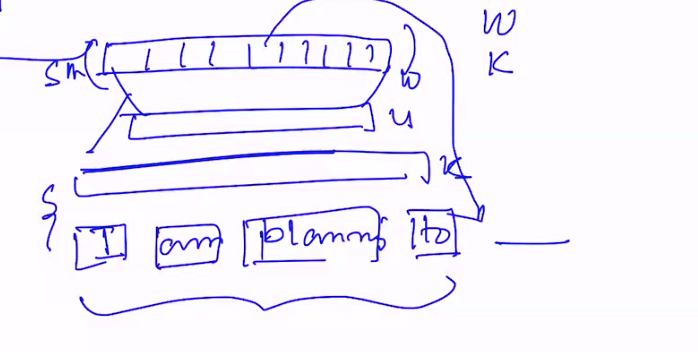

In [ ]:
# Inference
# run_inference(cnn_net, "IIT Delhi is", name="CNN")
run_inference(cnn_net, "hello world", name="CNN")


CNN Inference:
   Prompt: 'hello world'
   Result: "... hello world with in india established as college of engineering in 1961 ..."



'hello world with in india established as college of engineering in 1961'



---



# Will be continued...



---



# Recurrent Neural Network (RNN)

Unlike N-Grams, RNNs process data sequentially and maintain a Hidden State ($h_t$) which acts as a "short-term memory."

$$h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{t-1} + b_{hh})$$$$y_t = W_{hy} h_t + b_y$$

**Logic:** We will use *nn.RNN*. It iterates over the sequence length. We extract the last hidden state to predict the next word.

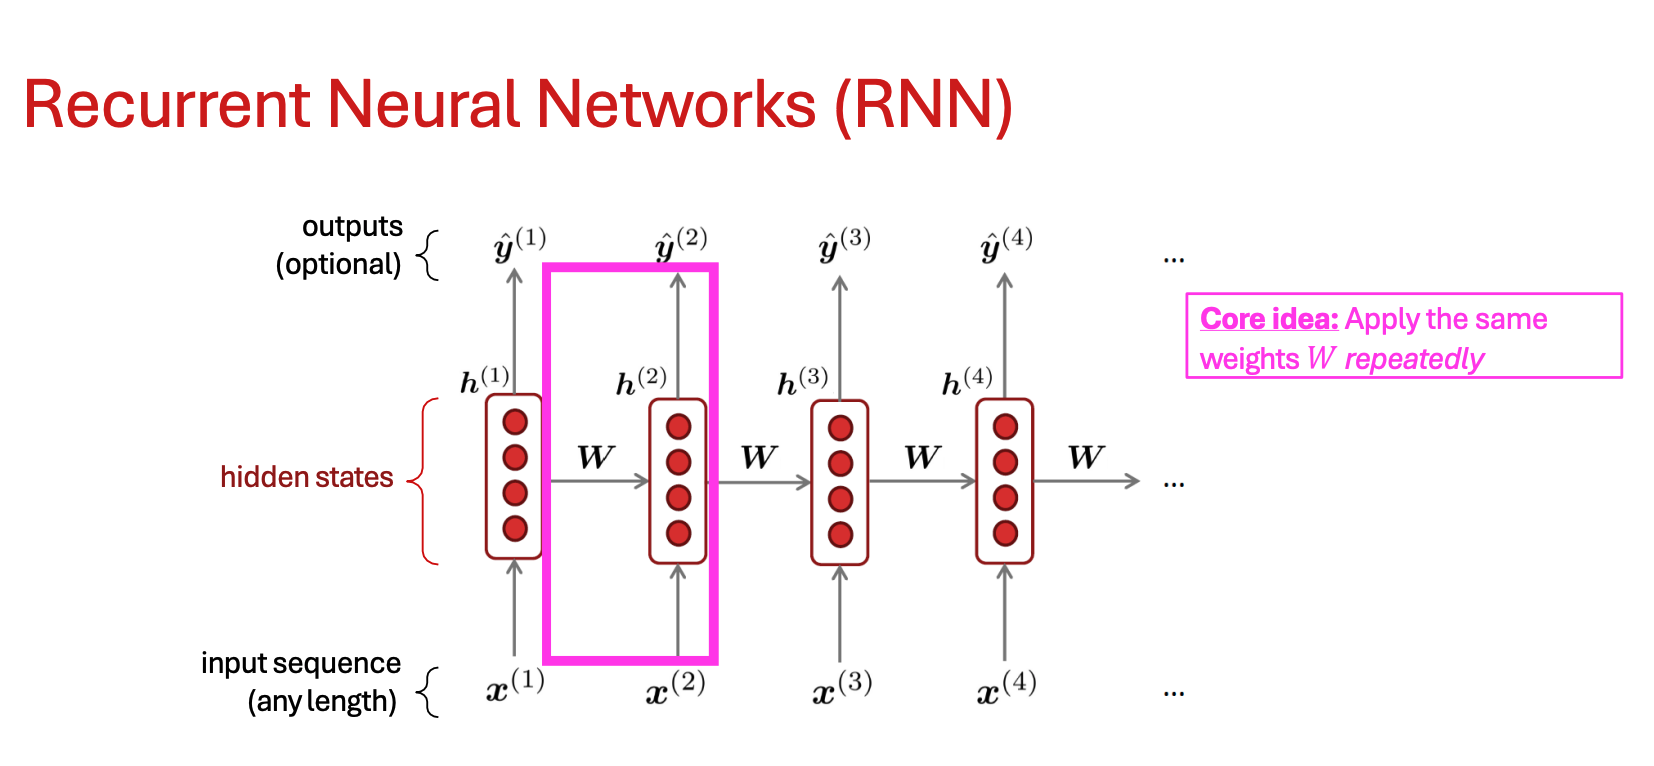

In [ ]:
# Theory: Hidden state h_t loops back to next step.
# Weakness: Vanishing Gradient.

class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, EMBED_DIM) # Turns ID 5 into a vector [0.1, -0.5, ...]
        self.rnn = nn.RNN(EMBED_DIM, HIDDEN_DIM, batch_first=True) # The Recurrent Layer, The "Loop" that passes hidden state forward, batch_first=True means input shape is (Batch, Seq_Len, Features)
        self.fc = nn.Linear(HIDDEN_DIM, VOCAB_SIZE) # Final decision layer, Maps hidden state to vocabulary size for prediction

    def forward(self, x):
        x = self.emb(x) # Embed Inputs, Convert IDs to Vectors
        out, h_n = self.rnn(x) # Pass through RNN. out contains outputs for all time steps, h_n is the final "summary" of the sentence (final hidden state).

        # We only care about the output of the LAST word to predict the NEXT word.
        # out[:, -1, :] means: All batches, Last time step, All features
        return self.fc(out[:, -1, :])

In [ ]:
# execution
rnn_net = RNNModel()

In [ ]:
# Dimension Check
dummy = torch.zeros((1, CONTEXT_SIZE), dtype=torch.long)
print(f"RNN Output Shape Check: {rnn_net(dummy).shape} (Should be [1, {VOCAB_SIZE}])")

RNN Output Shape Check: torch.Size([1, 123]) (Should be [1, 123])


In [ ]:
# Train
rnn_net = timed_run(train_and_log, rnn_net, name="RNN")

⏳ Training started...

Training RNN...
Epoch 1/150 | Loss: 4.8232
Epoch 50/150 | Loss: 0.0159
Epoch 100/150 | Loss: 0.0084
Epoch 150/150 | Loss: 0.0089
✅ Training finished.
⏱️ Time taken: 4.47 seconds


In [ ]:
# Inference
run_inference(rnn_net, "IIT Delhi is", name="RNN")

RNN Inference:
   Prompt: 'IIT Delhi is'
   Result: "... iit delhi is one of the 23 iits created to be centres of ..."



'iit delhi is one of the 23 iits created to be centres of'

# Long Short-Term Memory (LSTM)

Introduces a Cell State ($C_t$) that runs straight down the entire chain, acting like a super-highway for information. Gating mechanisms to regulate information flow.

* Forget Gate: $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$, "What irrelevant info (e.g., filler words) should I throw away?"
* Input Gate: $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$, "What new clinical symptom should I store?"
* Cell Update: $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$, "What should I output right now?"

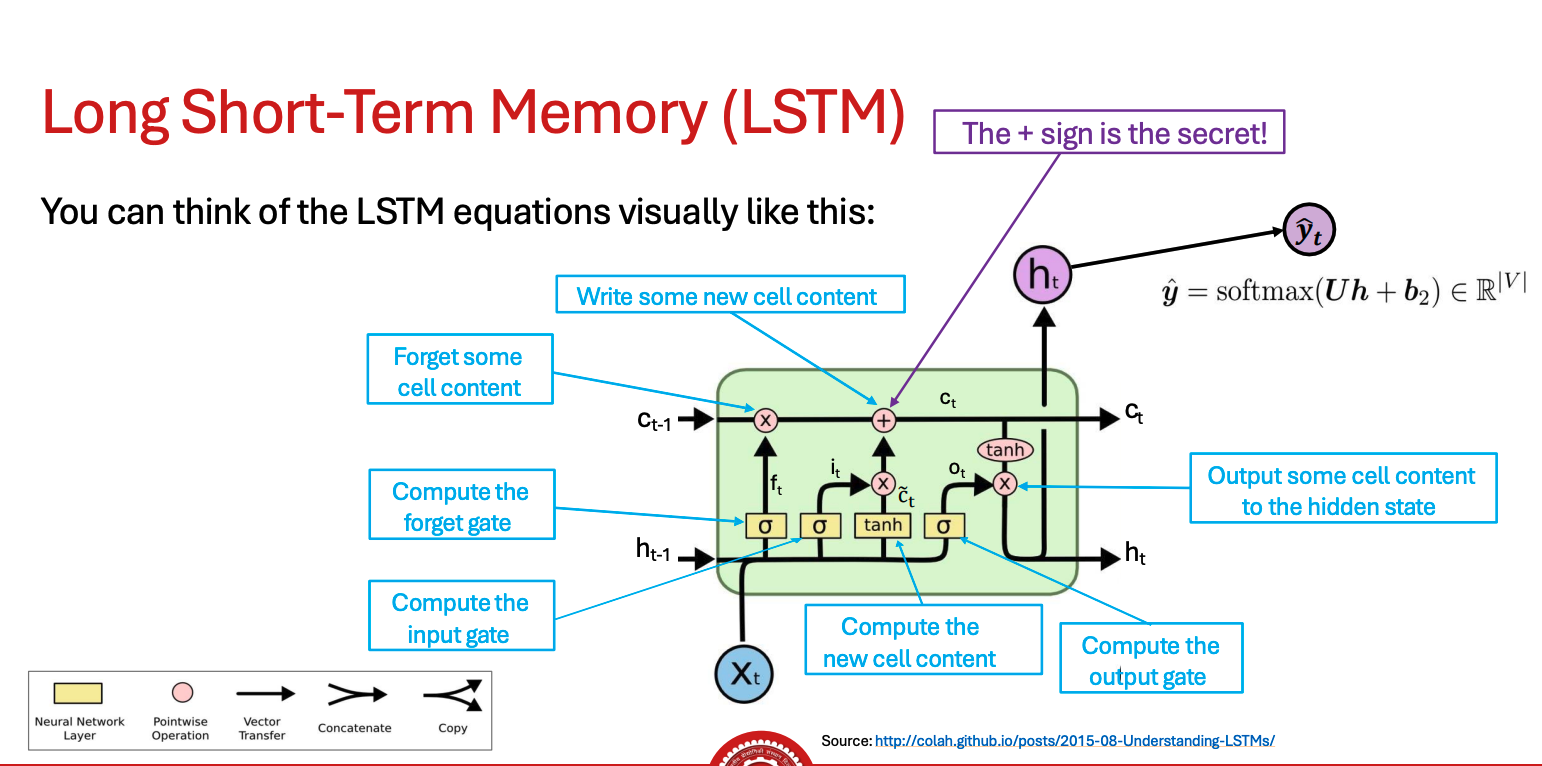

In [ ]:
# Theory: Adds Forget, Input, Output gates + Cell State (Long term memory).

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        # LSTM Layer: More complex than RNN, contains Gates (Input, Forget, Output)
        self.lstm = nn.LSTM(EMBED_DIM, HIDDEN_DIM, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, VOCAB_SIZE)

    def forward(self, x):
        x = self.emb(x)
        # LSTM returns: output, (hidden_state, cell_state); out, (h_n, c_n)
        # We only need the hidden state of the last time step for classification/prediction
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [ ]:
# exec
lstm_net = LSTMModel()

In [ ]:
# Dimension Check
print(f"LSTM Output Shape Check: {lstm_net(dummy).shape}")

LSTM Output Shape Check: torch.Size([1, 123])


In [ ]:
# Train
# lstm_net = train_and_log(lstm_net, name="LSTM")
lstm_net = timed_run(train_and_log, lstm_net, name="LSTM")

⏳ Training started...

Training LSTM...
Epoch 1/150 | Loss: 4.8241
Epoch 50/150 | Loss: 0.0114
Epoch 100/150 | Loss: 0.0137
Epoch 150/150 | Loss: 0.0078
✅ Training finished.
⏱️ Time taken: 6.80 seconds


In [ ]:
# Inference
run_inference(lstm_net, "IIT delhi is", name="LSTM")

LSTM Inference:
   Prompt: 'IIT delhi is'
   Result: "... iit delhi is one of the 23 iits created to be centres of ..."



'iit delhi is one of the 23 iits created to be centres of'

# Gated Recurrent Unit (GRU)

A simplified LSTM without a separate cell state.
It combines the forget and input gates into a single "Update Gate" $z_t$.

**Benefit**: They are faster to train and require less computational power.

$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$$$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$$$$h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$$

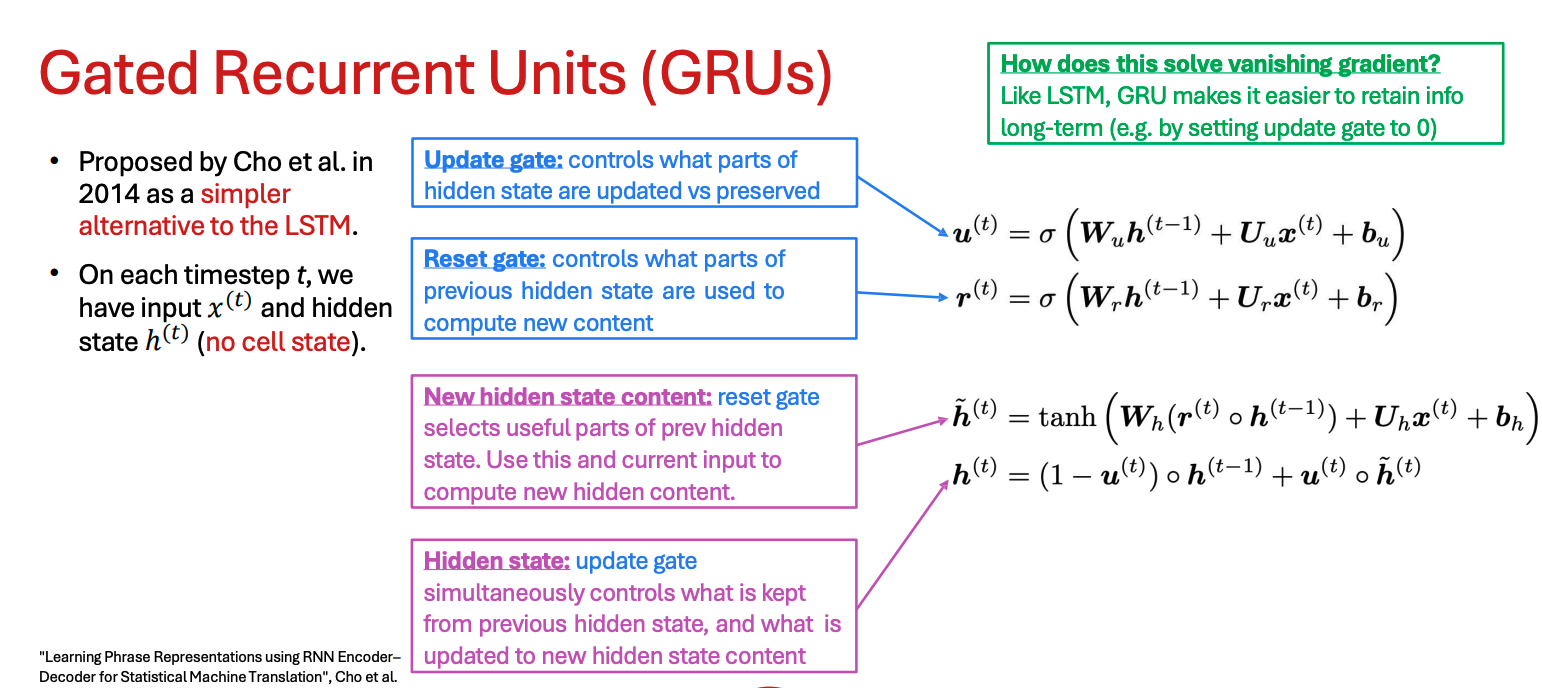

In [ ]:
# Merges Cell/Hidden states. Merges Input/Forget gates -> Update Gate.

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        # GRU Layer: Merges cell state and hidden state for efficiency
        self.gru = nn.GRU(EMBED_DIM, HIDDEN_DIM, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, VOCAB_SIZE)

    def forward(self, x):
        x = self.emb(x)
        # out, h_n
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

In [ ]:
# exec
gru_net = GRUModel()

In [ ]:
# Dimension Check
dummy = torch.zeros((1, CONTEXT_SIZE), dtype=torch.long)
print(f"GRU Output Shape Check: {gru_net(dummy).shape}")

GRU Output Shape Check: torch.Size([1, 123])


In [ ]:
# Train
# gru_net = train_and_log(gru_net, name="GRU")
gru_net = timed_run(train_and_log, gru_net, name="GRU")

⏳ Training started...

Training GRU...
Epoch 1/150 | Loss: 4.8787
Epoch 50/150 | Loss: 0.0097
Epoch 100/150 | Loss: 0.0142
Epoch 150/150 | Loss: 0.0091
✅ Training finished.
⏱️ Time taken: 7.14 seconds


In [ ]:
# Inference
run_inference(gru_net, "IIT Delhi is", name="GRU")

GRU Inference:
   Prompt: 'IIT Delhi is'
   Result: "... iit delhi is one of the 23 iits created to be centres of ..."



'iit delhi is one of the 23 iits created to be centres of'

# Results

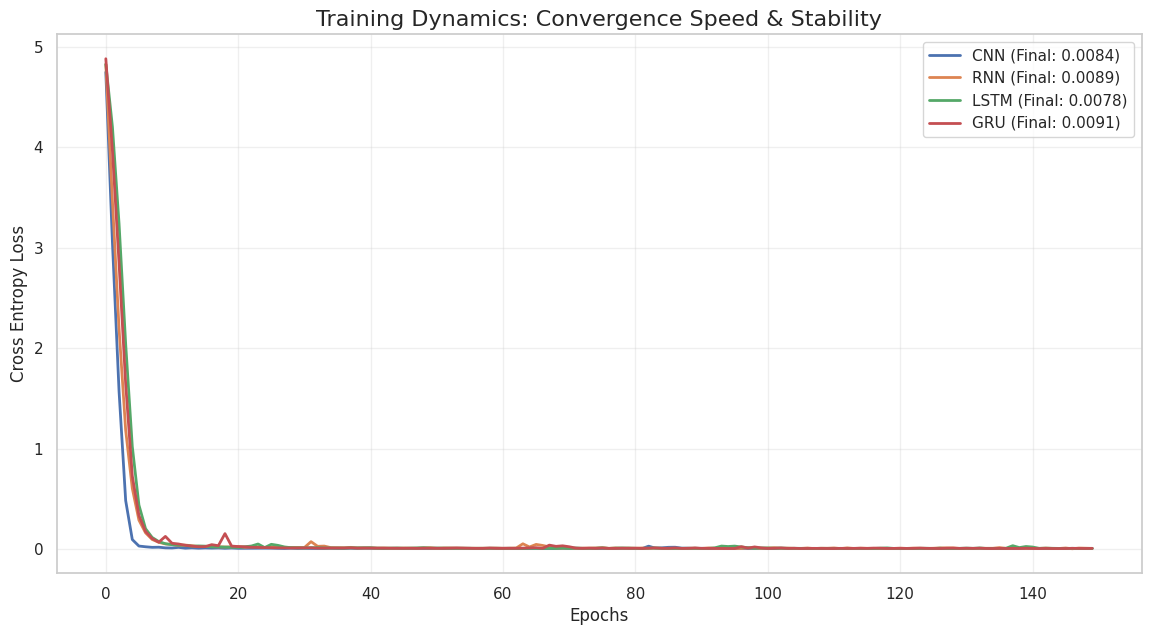

In [ ]:
# 1. Visualization of Loss Curves
plt.figure(figsize=(14, 7))
for name, losses in HISTORY_STORE.items():
    plt.plot(losses, label=f"{name} (Final: {losses[-1]:.4f})", linewidth=2)

plt.title("Training Dynamics: Convergence Speed & Stability", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 2. Generated Text Comparison Table
print("\n📝 GENERATION CAPABILITY CHECK (Prompt: 'iit delhi is...')")
print("-" * 80)
print(f"{'MODEL':<10} | {'GENERATED SEQUENCE'}")
print("-" * 80)

for name, text in PREDICTION_STORE.items():
    # Truncate for display
    clean_text = text.replace("\n", " ")
    print(f"{name:<10} | {clean_text}")


📝 GENERATION CAPABILITY CHECK (Prompt: 'iit delhi is...')
--------------------------------------------------------------------------------
MODEL      | GENERATED SEQUENCE
--------------------------------------------------------------------------------
N-Gram     | indian institute of technology
CNN        | iit delhi is one of the 23 iits created to be centres of
RNN        | iit delhi is one of the 23 iits created to be centres of
LSTM       | iit delhi is one of the 23 iits created to be centres of
GRU        | iit delhi is one of the 23 iits created to be centres of
